2.18.0
True
(30000, 25)
2    18112
1    18112
Name: SEX, dtype: int64
4.079080201906899
PR-AUC: 0.5841809297696646
Model Accuracy: 0.8438
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7303
           1       0.68      0.37      0.48      1753

    accuracy                           0.84      9056
   macro avg       0.77      0.66      0.69      9056
weighted avg       0.83      0.84      0.83      9056


Final Training Log Loss: 0.2983
Final Test Log Loss: 0.3938


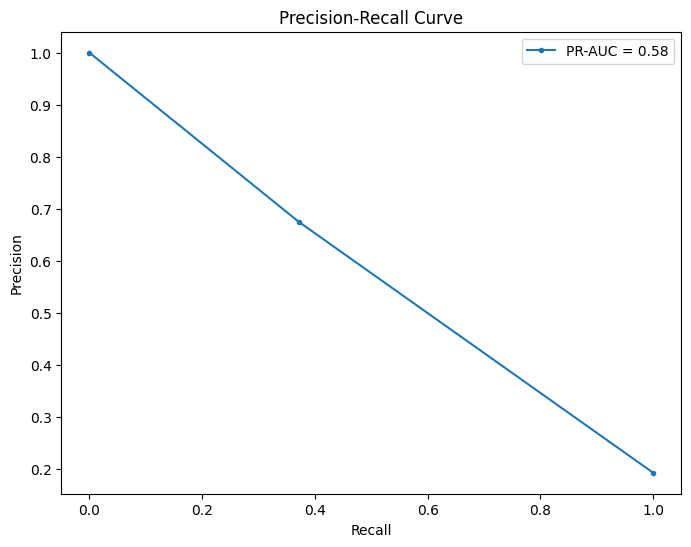

In [7]:
%run /home/jui/thesis-code/Thesis-code/rai-img-merged/Improved-model.ipynb

In [8]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier

import warnings
warnings.filterwarnings('ignore')

# Select random 7500 samples using positional indexing
subset_indices = np.random.choice(len(y_train), 7500, replace=False)
X_train_subset = X_train.iloc[subset_indices]  # Use .iloc for positional indexing
y_train_subset = y_train[subset_indices]  # Direct positional indexing for NumPy array


def get_adversarial_examples(X_train_subset, pipeline, model):
    """
    Generate adversarial examples using the ZooAttack method.

    Args:
        X_train_subset (np.ndarray): Subset of training data (raw features).
        y_train_subset (np.ndarray): Corresponding labels for the subset.
        pipeline (Pipeline): The original pipeline containing preprocessing and model.

    Returns:
        np.ndarray: Adversarial examples.
    """
    # Extract the preprocessor and model from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']

    # Preprocess the subset of training data using the pipeline's preprocessor
    X_train_subset_preprocessed = preprocessor.transform(X_train_subset)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(
        model=model,
        nb_features=X_train_subset_preprocessed.shape[1],
        nb_classes=2)

    # Create the ZooAttack instance
    zoo = ZooAttack(
        classifier=art_classifier,
        confidence=0.0,
        targeted=False,
        learning_rate=1e-1,
        max_iter=50,
        binary_search_steps=10,
        initial_const=1e-3,
        abort_early=True,
        use_resize=False,
        use_importance=False,
        nb_parallel=5,
        batch_size=1,
        variable_h=0.01
    )

    # Generate adversarial examples
    x_train_adv = zoo.generate(X_train_subset_preprocessed)

    return x_train_adv

In [10]:
x_train_adv = get_adversarial_examples(X_train_subset, pipeline, model)

ZOO: 100%|██████████| 7500/7500 [11:10<00:00, 11.19it/s]


Accuracy on Test Set: 83.01%


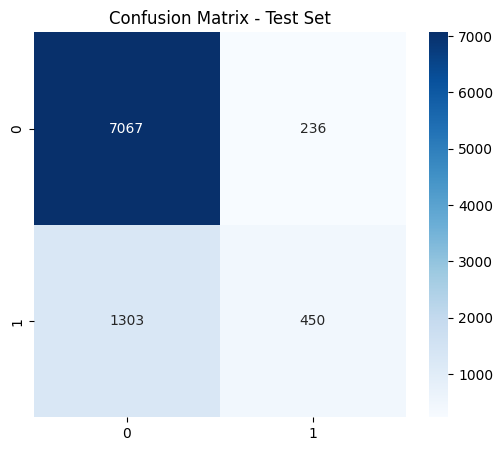

In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Convert all datasets to NumPy arrays before training
xgb_model.fit(x_train_adv, y_train_subset,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [13]:
def label_flip_attack(y_train: np.ndarray, flip_percent: float) -> np.ndarray:
    """
    Flip labels in y_train by a specified percentage.
    
    Args:
        y_train (np.ndarray): Original training labels.
        flip_percent (float): Percentage of labels to flip (0-100).

    Returns:
        np.ndarray: Poisoned labels with flipped values.
    """
    y_poisoned = y_train.copy()
    n_samples = len(y_train)
    n_flip = int((flip_percent / 100) * n_samples)  # Number of labels to flip
    
    flip_indices = np.random.choice(np.arange(n_samples), size=n_flip, replace=False)

    # Flip binary labels (assuming labels are 0 and 1)
    y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]  # Flip 0->1 and 1->0
    
    return y_poisoned



Accuracy on Test Set: 78.77%


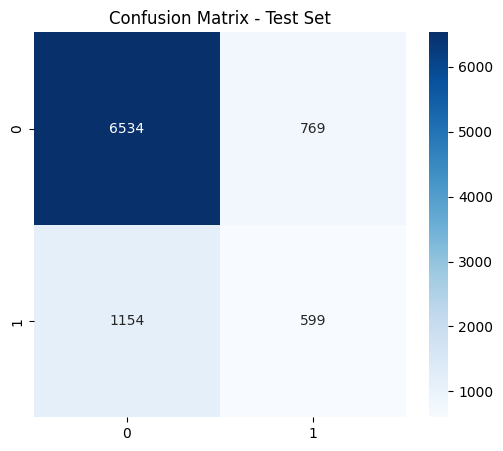

In [14]:
# Define the percentage of labels to flip
flip_percent = 35  # Flip 20% of labels

# Apply label flipping attack
y_train_poisoned = label_flip_attack(y_train, flip_percent)

# Step 2: Train model on poisoned labels
xgb_model.fit(X_train, y_train_poisoned, verbose=False)

# Step 3: Evaluate model on test set
y_pred_test = xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Step 4: Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()